In [554]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [586]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
using Gurobi
const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-28


Gurobi.Env(Ptr{Nothing} @0x000000001a429800, false, 0)

### Interaction planner

In [571]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [572]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [30.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [-20.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [573]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.098351 seconds (418.58 k allocations: 37.459 MiB)


  0.086390 seconds (387.22 k allocations: 34.427 MiB)


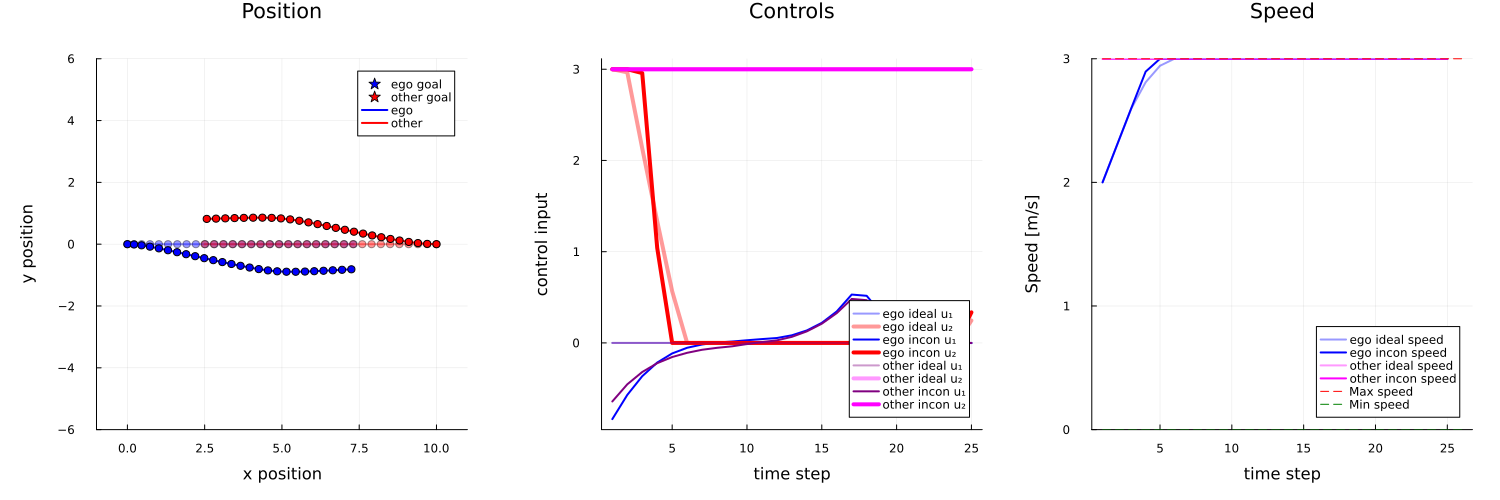

In [574]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [575]:
@time IteratedBestResponse(ip, 3, "ego")

  0.056538 seconds (250.29 k allocations: 21.700 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


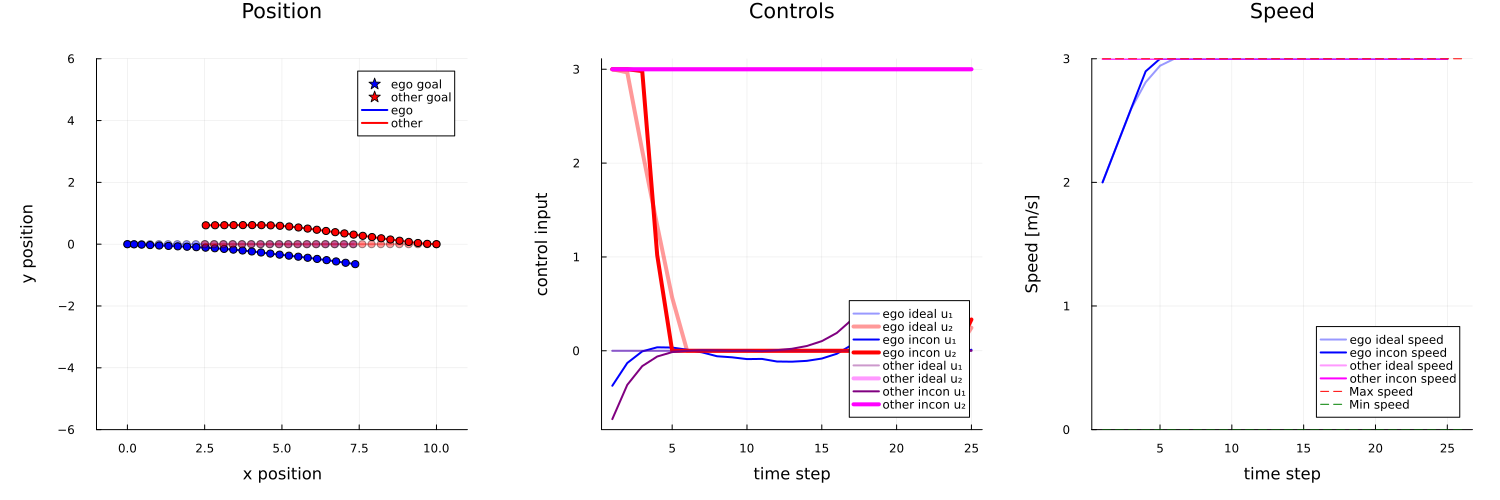

In [576]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /tmp/jl_lKlEb6niZy.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_lKlEb6niZy.gif")
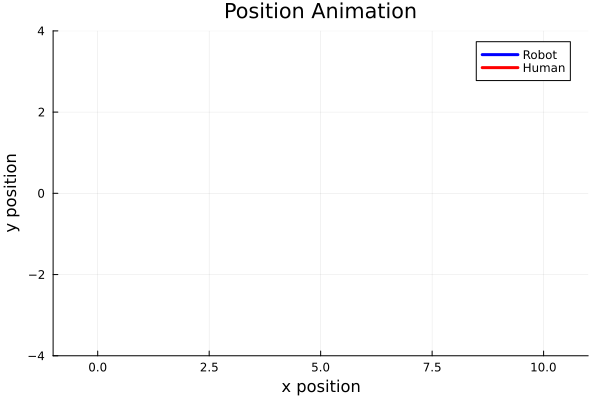

In [577]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

Int64

┌ Info: Saved animation to /tmp/jl_rkR8tCjkji.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_rkR8tCjkji.gif")
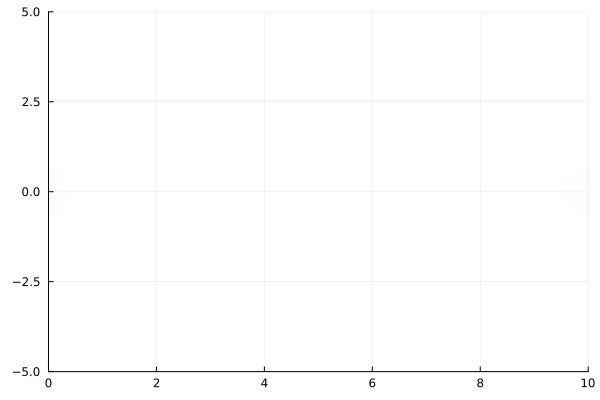

In [578]:
special_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# Simple sim using ideal inputs from either agent

In [579]:
robot_states = Vector{Vector{Float64}}(undef, 30);
robot_controls = Vector{Vector{Float64}}(undef, 30);
human_states = Vector{Vector{Float64}}(undef, 30);
human_controls = Vector{Vector{Float64}}(undef, 30);

In [587]:
for i in 1:30
    ip.ego_planner.incon.opt_params.initial_state = step(robot, ip.ego_planner.incon.opt_params.previous_states[1], ip.ego_planner.incon.opt_params.previous_controls[1])
    ip.other_planner.incon.opt_params.initial_state = step(human, ip.other_planner.incon.opt_params.previous_states[1], ip.other_planner.incon.opt_params.previous_controls[1])
    IteratedBestResponseMPC(ip, 3, "ego");
    push!(robot_states, ip.ego_planner.incon.opt_params.previous_states[1])
    deleteat!(robot_states, 1)
    push!(robot_controls, ip.ego_planner.incon.opt_params.previous_controls[1])
    deleteat!(robot_controls, 1)
    push!(human_states, ip.other_planner.incon.opt_params.previous_states[1])
    deleteat!(human_states, 1)
    push!(human_controls, ip.other_planner.incon.opt_params.previous_controls[1])
    deleteat!(human_controls, 1)
end
ip.ego_planner.incon.opt_params.previous_states = robot_states;
ip.ego_planner.incon.opt_params.previous_controls = robot_controls;
ip.other_planner.incon.opt_params.previous_states = human_states;
ip.other_planner.incon.opt_params.previous_controls = human_controls;



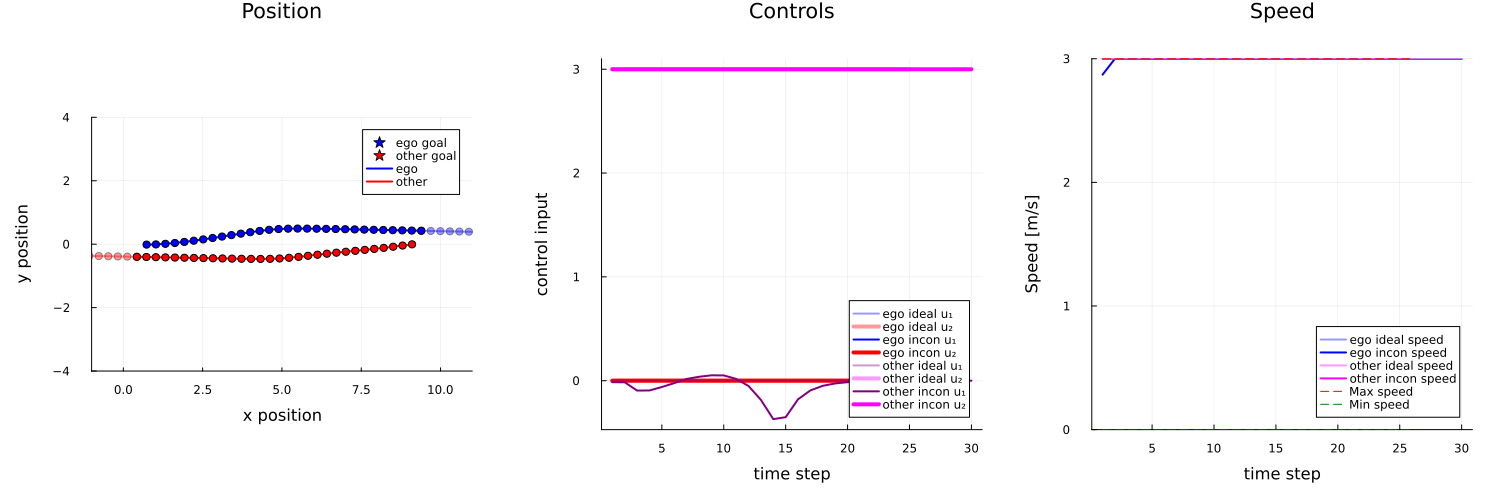

In [588]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])